# napari and magicgui

One of the most interesting features of napari, is that it lets you add relatively easily Graphical User Interface (GUI) elements to the napari viewer. There are two ways to create such a GUI: one automated way using a package called ```magicgui``` and a more complex one using the ```Qt``` library which offers more flexibility. We start here with a brief example using ```magicgui``` and see the ```Qt``` version in the last chapter when we create a plugin.

In [1]:
from magicgui import magicgui, magic_factory
from magicgui import widgets

In [2]:
from magicgui import use_app
use_app("ipynb")

<magicgui app, wrapping the ipynb GUI toolkit>

## magicgui

napari is built on top of the library Qt. One can of course add directly new Qt elements, or widgets, to the viewer, but it requires some knowledge about how Qt works. Instead of this we can use the magicgui library which takes care of a lot of boiler plate for us if we just need a simple to medium complicated interfaces. 

The idea of magicgui is that it takes a function and turns it into an interface with buttons, sliders etc. depending on the inputs and outputs. For example if one of the parameters of the function is an integer, it will create a SpinBox, a field with two buttons to in- decrease the value of the integer.

### Example without napari

magicgui is not tied to napari. We start here by making simple GUIs and we'll see later how this works with napari. This is a simplified version of what you find in the [documentation](https://napari.org/magicgui/usage/quickstart.html). 

#### Creating a GUI manually

Before we look at how we can automatically generate widgets using functions, we create here an interface manually, which is a bit more natural as a start. For this we use the `widgets` module of magicgui. This one allows us for example to create a spinbox. Each type of widget has its own set of options. For example here we set a default value, a max and min value and a label:

In [3]:
myspinbox = widgets.SpinBox(value=10, min=0, max=100, label="a")

There are many other widgets. Here we create in addition a slider, an editable line and a button:

In [4]:
myslider = widgets.Slider(value=20, min=0, max=100, label="b")
result = widgets.LineEdit(value=myspinbox.value * myslider.value, label="result")
button = widgets.PushButton(text="multiply")

And finally we can put everything together into a container:

In [5]:
container = widgets.Container(widgets=[myspinbox, myslider, result, button])
container

Now we have an interactive GUI where we can adjust sliders, click on the button etc. However nothing happens when we interact. So the next step is to **connect** our widgets to some actions. For this we need to
1. Create a function that will be executed *when* an action is done
2. Connect that function to the action

Let's creata a dummy print function:

In [6]:
def dummy_print():
    print('clicked!')

Now we connect. The `.clicked` indicates that something happens when we click on the button:

In [7]:
button.clicked.connect(dummy_print)

<function __main__.dummy_print()>

More interestingly we can edit *other* widgets when clicking on the widgets. Each widget has multiple properties, and some of those can be set. For example the `reslult` box has a `value`:

In [8]:
result.value

'200'

So we can edit that we we click on the button:

In [9]:
def dummy_print():
    result.value = 'clicked!'

In [10]:
button.clicked.connect(dummy_print)

<function __main__.dummy_print()>

In [11]:
container.show()

Finally, we would rather show the result of an actual computation. So, inside our called function we can use the values of the slider and spinbox to do a computation:

In [12]:
def dummy_print():
    result.value = spinbox.value * myslider.value
button.clicked.connect(dummy_print)

container.show()

#### Function to GUI

Now let's see how we can go directly from function to GUI. First we define a very simple function:

In [13]:
def my_little_function(my_parameter=30):
    
    out = np.sin(my_parameter) ** 2
    return out

Now we turn it into a GUI by passing it to the ```magicgui``` function. We also pass an additional parameter here called ```call_button``` to change the name of the button that executes the function:

In [14]:
my_little_function = magicgui(my_little_function, call_button="calculate")

Now we can visualize our interface (it will appear as a separate window):

In [15]:
my_little_function.show(run=True)

Note that simply because our function took an argument ```my_parameter=30``` magicgui generated a spinbox for an integer number!

Now we can execute our function as a normal function, using the default value or a new one:

In [16]:
my_little_function()

np.float64(0.9762064902075782)

In [17]:
my_little_function(my_parameter=2)

np.float64(0.826821810431806)

But we can also change the value in the interface and then execute the function:

In [18]:
my_little_function.show(run=True)

In [19]:
my_little_function()


np.float64(0.9762064902075782)

So the interface allows us to control the value of ```my_parameter```!

### Decorator

Note that in many cases you won't see the line:
```python
my_little_function = magicgui(my_little_function, call_button="calculate")
```

but rather this:
```python
@magicgui(call_button="calculate")
def my_little_function(my_parameter=30):
    
    out = np.sin(my_parameter) ** 2
    return out
```

This way of using the ```magicgui``` function is called a decorator. It's a short notation for what we did above but works entirely the same way! One can also use the ```magic_factory``` annotation from magicgui which creates a GUI class instead of directly an instance of it.

### Connecting

For the moment we haven't used the ```calculate``` button. It does execute the function when we press on it, but nothing else really happens: we can't recover the calculation. For that we need to add a **callback** the the button, i.e. we need to link the button with a function that gets executed when it's pressed. Also the function takes as input the output of the function executed by the button:

In [20]:
def my_callback(value):
    
    print(f"Your function was called! The result is: {value}")

In [21]:
my_little_function.called.connect(my_callback)

<function __main__.my_callback(value)>

In [22]:
my_little_function.show(run=True)

## napari and magicgui

**Restart the notebook here!**

The logic with napari is very similar. We just have to know what inputs/outputs are allowed and we need to add the interface to napari. We define a tiny workflow that simply computes a mask:

In [1]:
def workflow(image, threshold):
    im_th = image > threshold
    im_th = skimage.measure.label(im_th)
    return im_th

If we just turn this function into a GUI, napari will not know what it's supposed to do with the inputs and outputs. For example, we create here a mask image: when we press ```calculate``` we want the output to be added as a ```Labels``` layer and not an ```Image``` layer. We thus have to give a **hint** to napari. For that we specify the expected type of input/output. We can import these types from napari:

In [3]:
from napari.layers import Image
from napari.types import LabelsData

and then use them in our function definition. Note that:

- we can also use strings for types to avoid having to import napari directly
- we can use either Layer types such as ```Image``` or Layer data types like ```ImageData```. It depends whether we want to pass/get full layers or just the data.

We make here an example using ```magic_factory```. We want to pass an image layer as input. This will create automatically a dropdown menu with only image layers listed. And we want to return Labels data:

In [14]:
import napari
from napari.utils import nbscreenshot
import skimage
import numpy as np

from magicgui import magic_factory

#@magicgui(call_button="execute", layout="vertical")
@magic_factory(call_button="execute", layout="vertical")
def workflow(layer_image: "napari.layers.Image", threshold=100) -> LabelsData:
    im_th = layer_image.data > threshold
    im_th = skimage.measure.label(im_th)
    return im_th

mywidget = workflow()

Now we say that the input should be a napari layer (from which we grab then the ```data```), and the output should be an ```ImageData```. The last thing we have to learn: how to add the interface to napari? This is very simple: once we have a ```viewer``` we can just use ```viewer.window.add_dock_widget```:

In [18]:
viewer = napari.Viewer()
viewer.open_sample(plugin='napari', sample='human_mitosis')
viewer.window.add_dock_widget(mywidget, area="right");

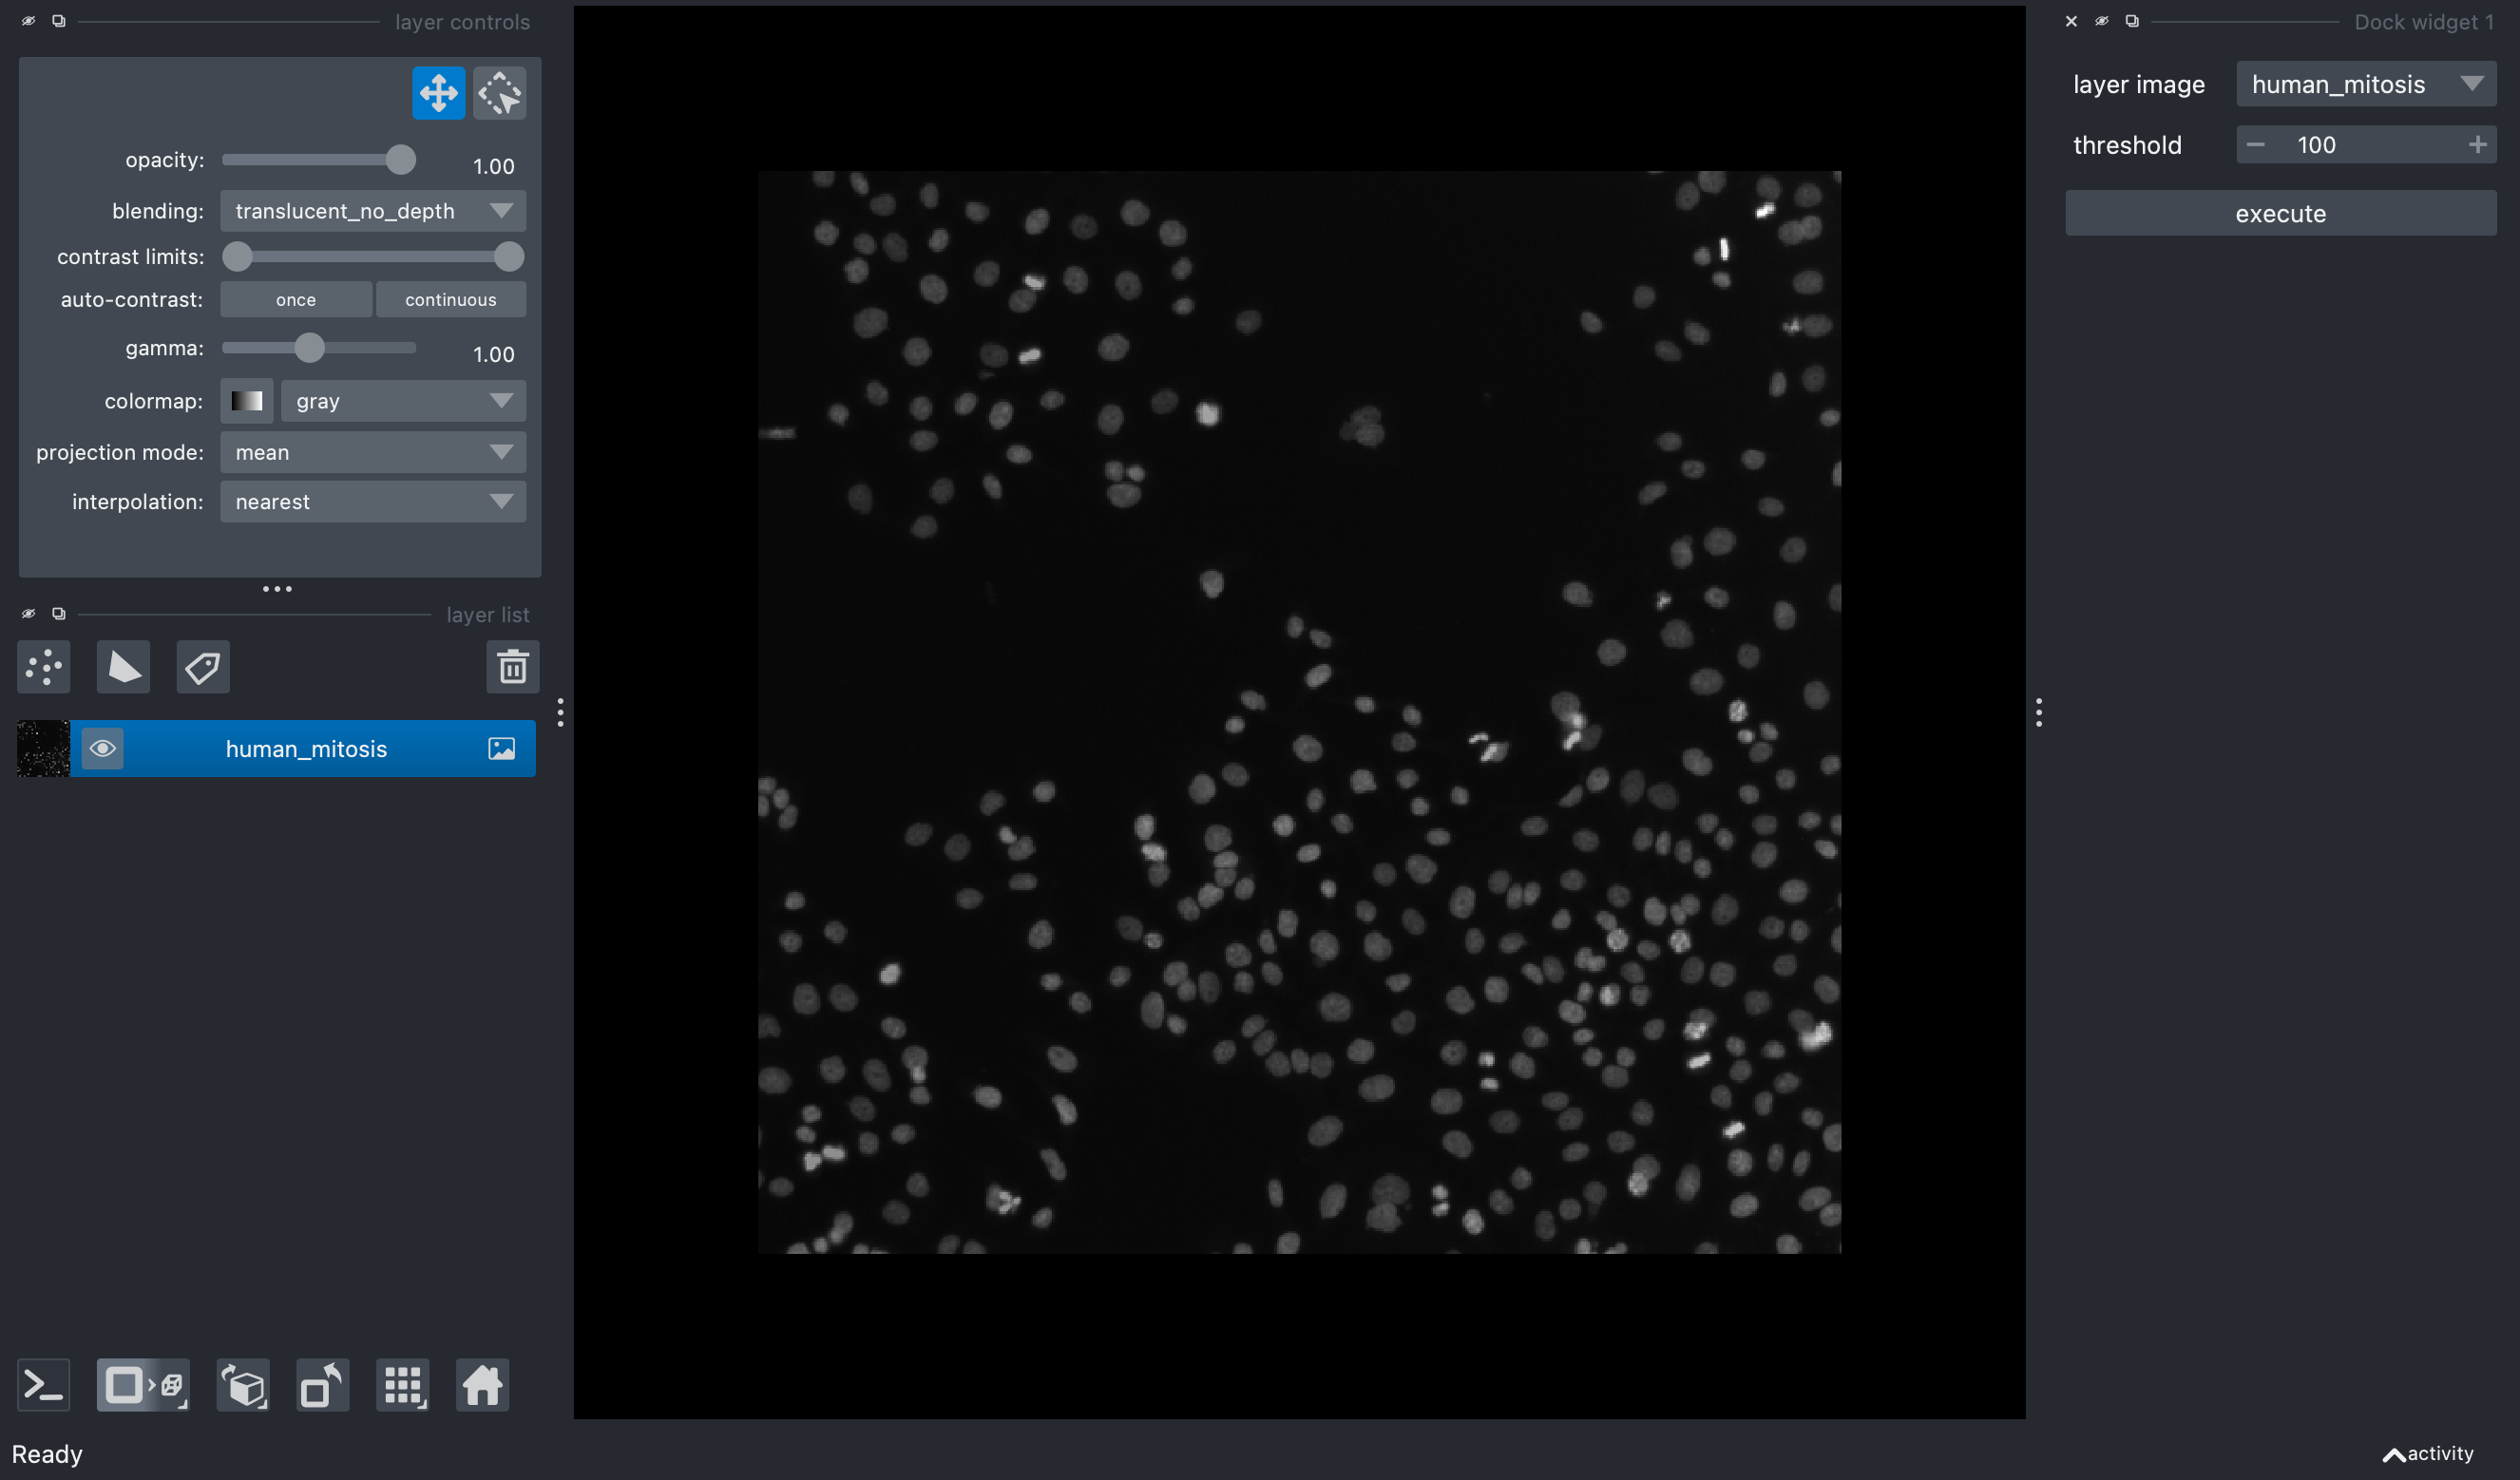

In [19]:
nbscreenshot(viewer)

Now we can pick a layer (note that the list is made for us) and click on the button:

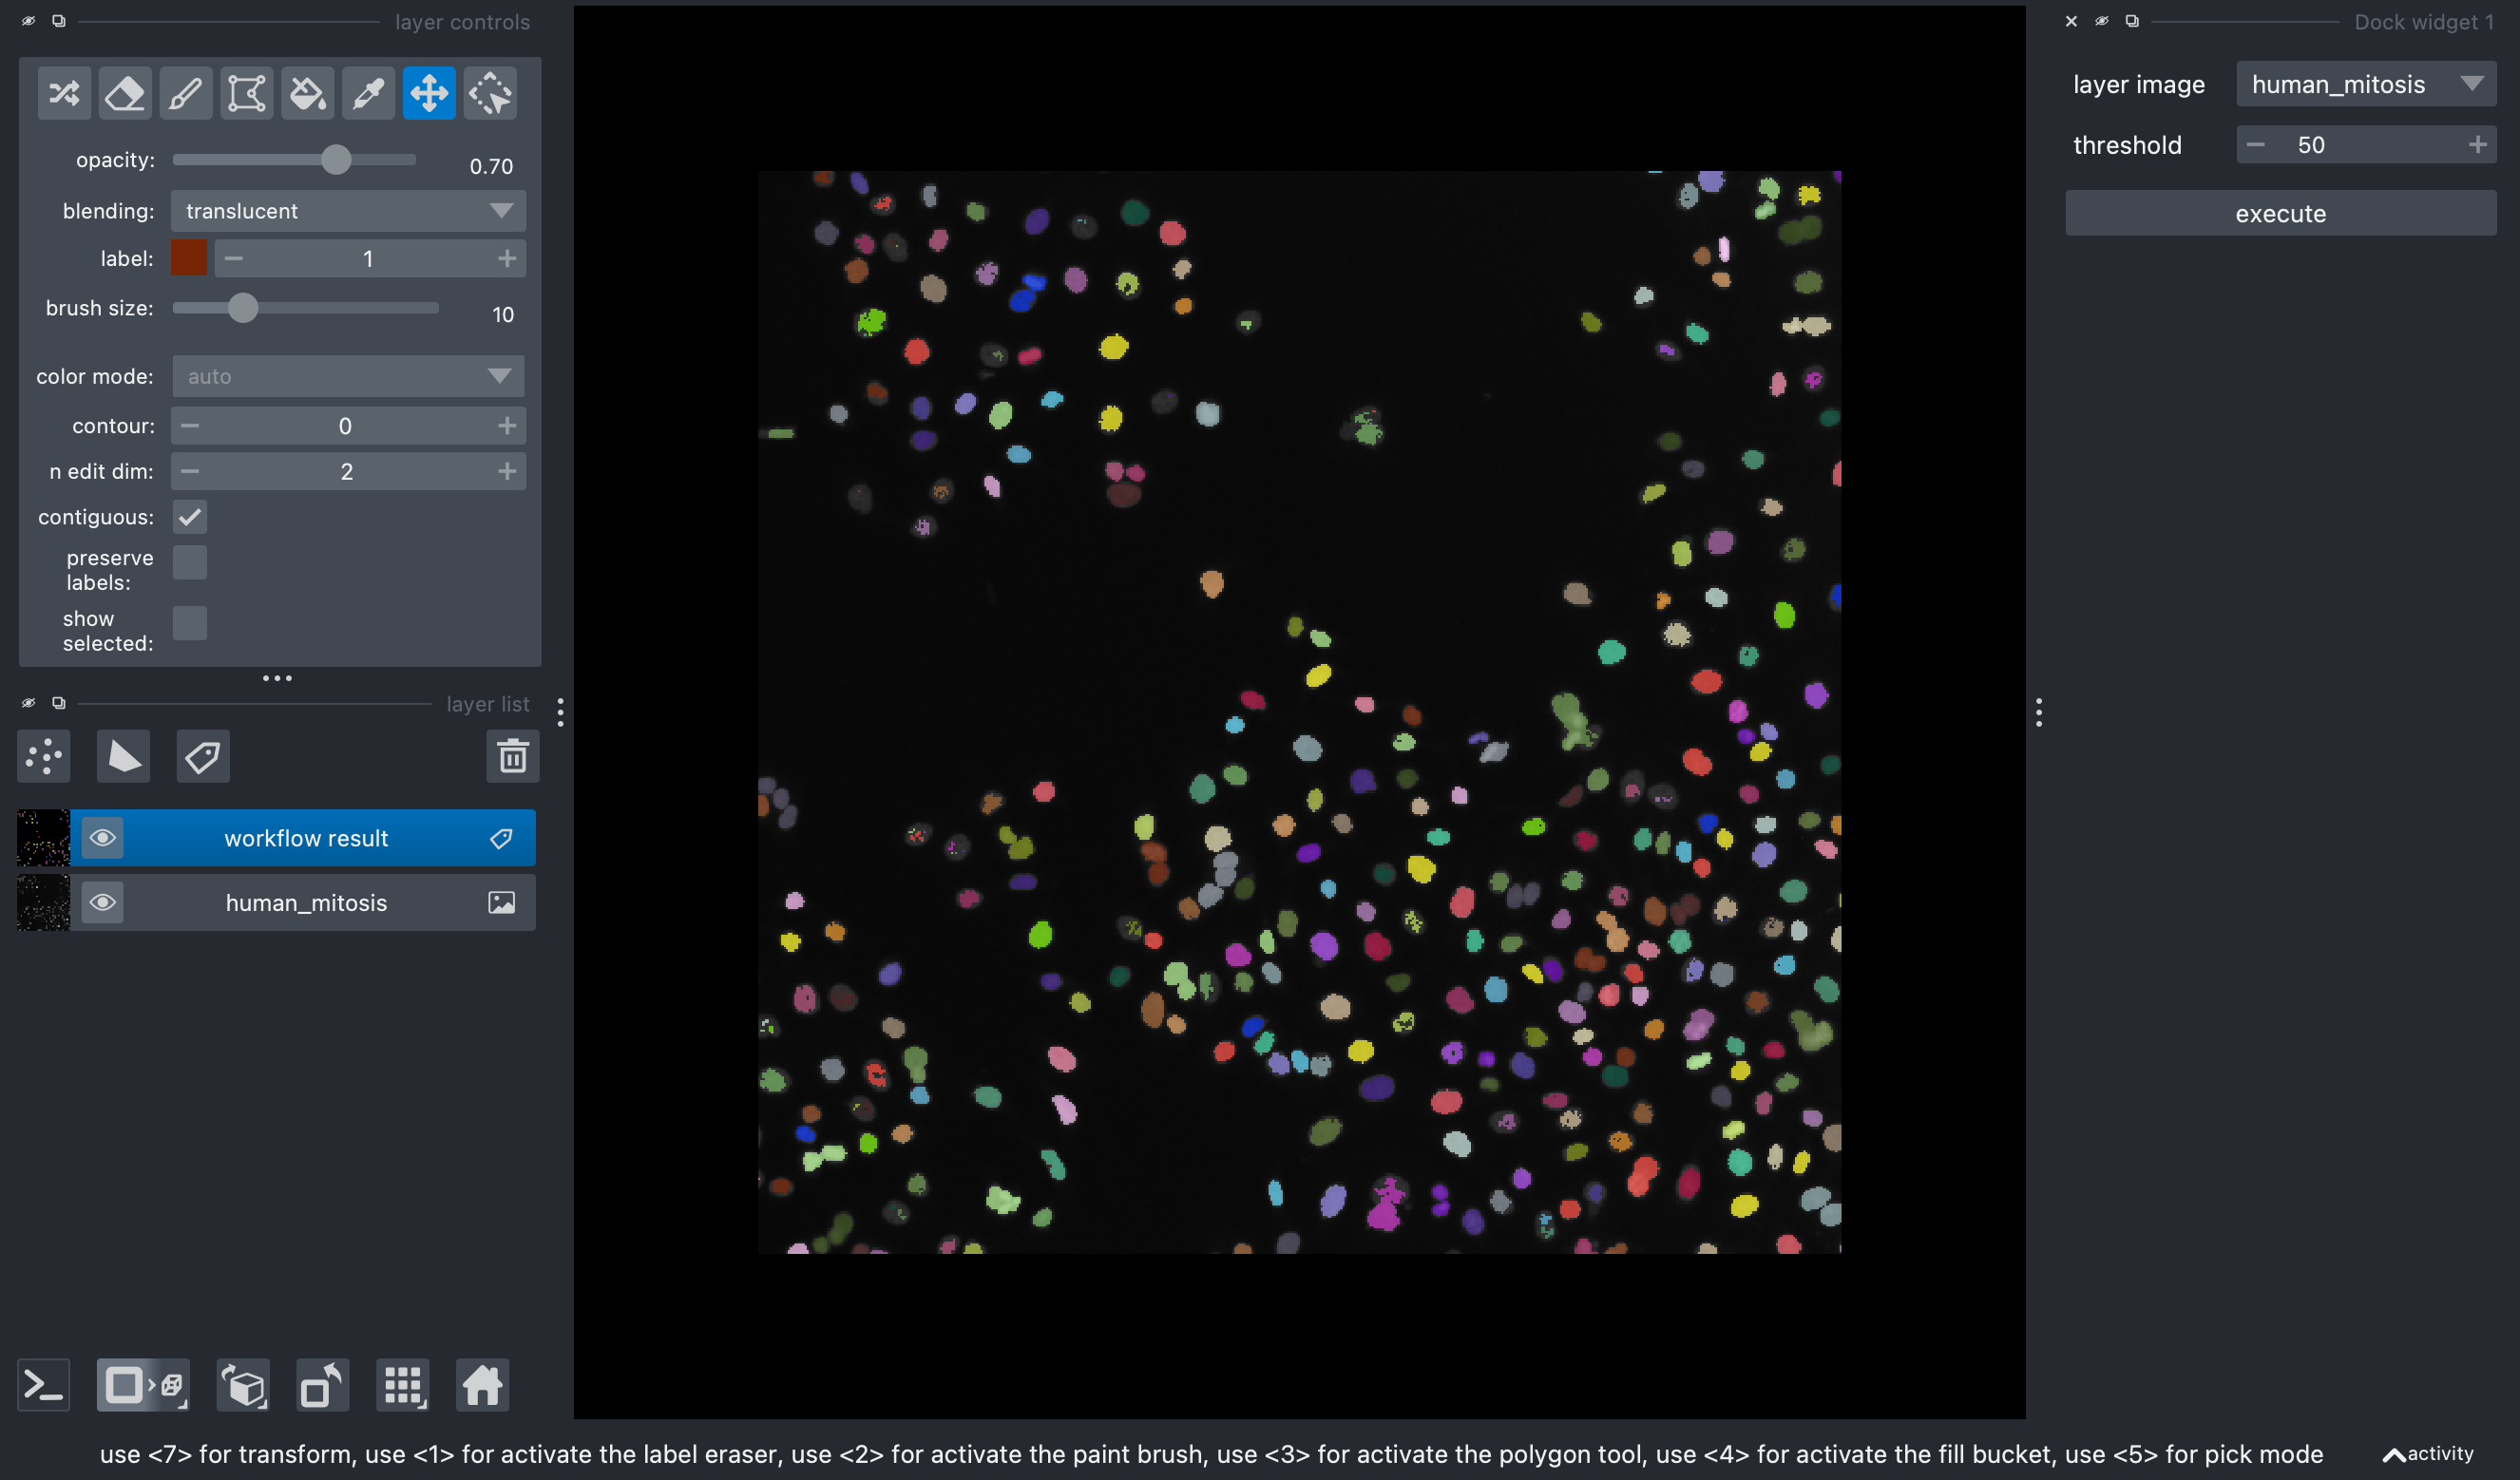

In [21]:
nbscreenshot(viewer)

### Layer data tuple

Alternatively to return just the data, we can return more information in the form of a `LayerDataTuple`. This tuple contains the data and then optionally a dictionary to format the layer (e.g. colormaps) and the layer type: 

In [23]:
from napari.types import LayerDataTuple


@magic_factory(call_button="execute", layout="vertical")
def workflow(layer_image: "napari.layers.Image", threshold=100) -> LayerDataTuple:
    im_th = layer_image.data > threshold
    im_th = skimage.measure.label(im_th)
    return (im_th, {'name': 'my computation'}, 'labels')

mywidget = workflow()


viewer = napari.Viewer()
viewer.open_sample(plugin='napari', sample='human_mitosis')
viewer.window.add_dock_widget(mywidget, area="right");

int32


## Modify the widget

Since with magic_factory we create instances of objects, we can also modify them once created. For example we could change the name of the button:

In [24]:
mywidget.call_button.text = 'Threshold'

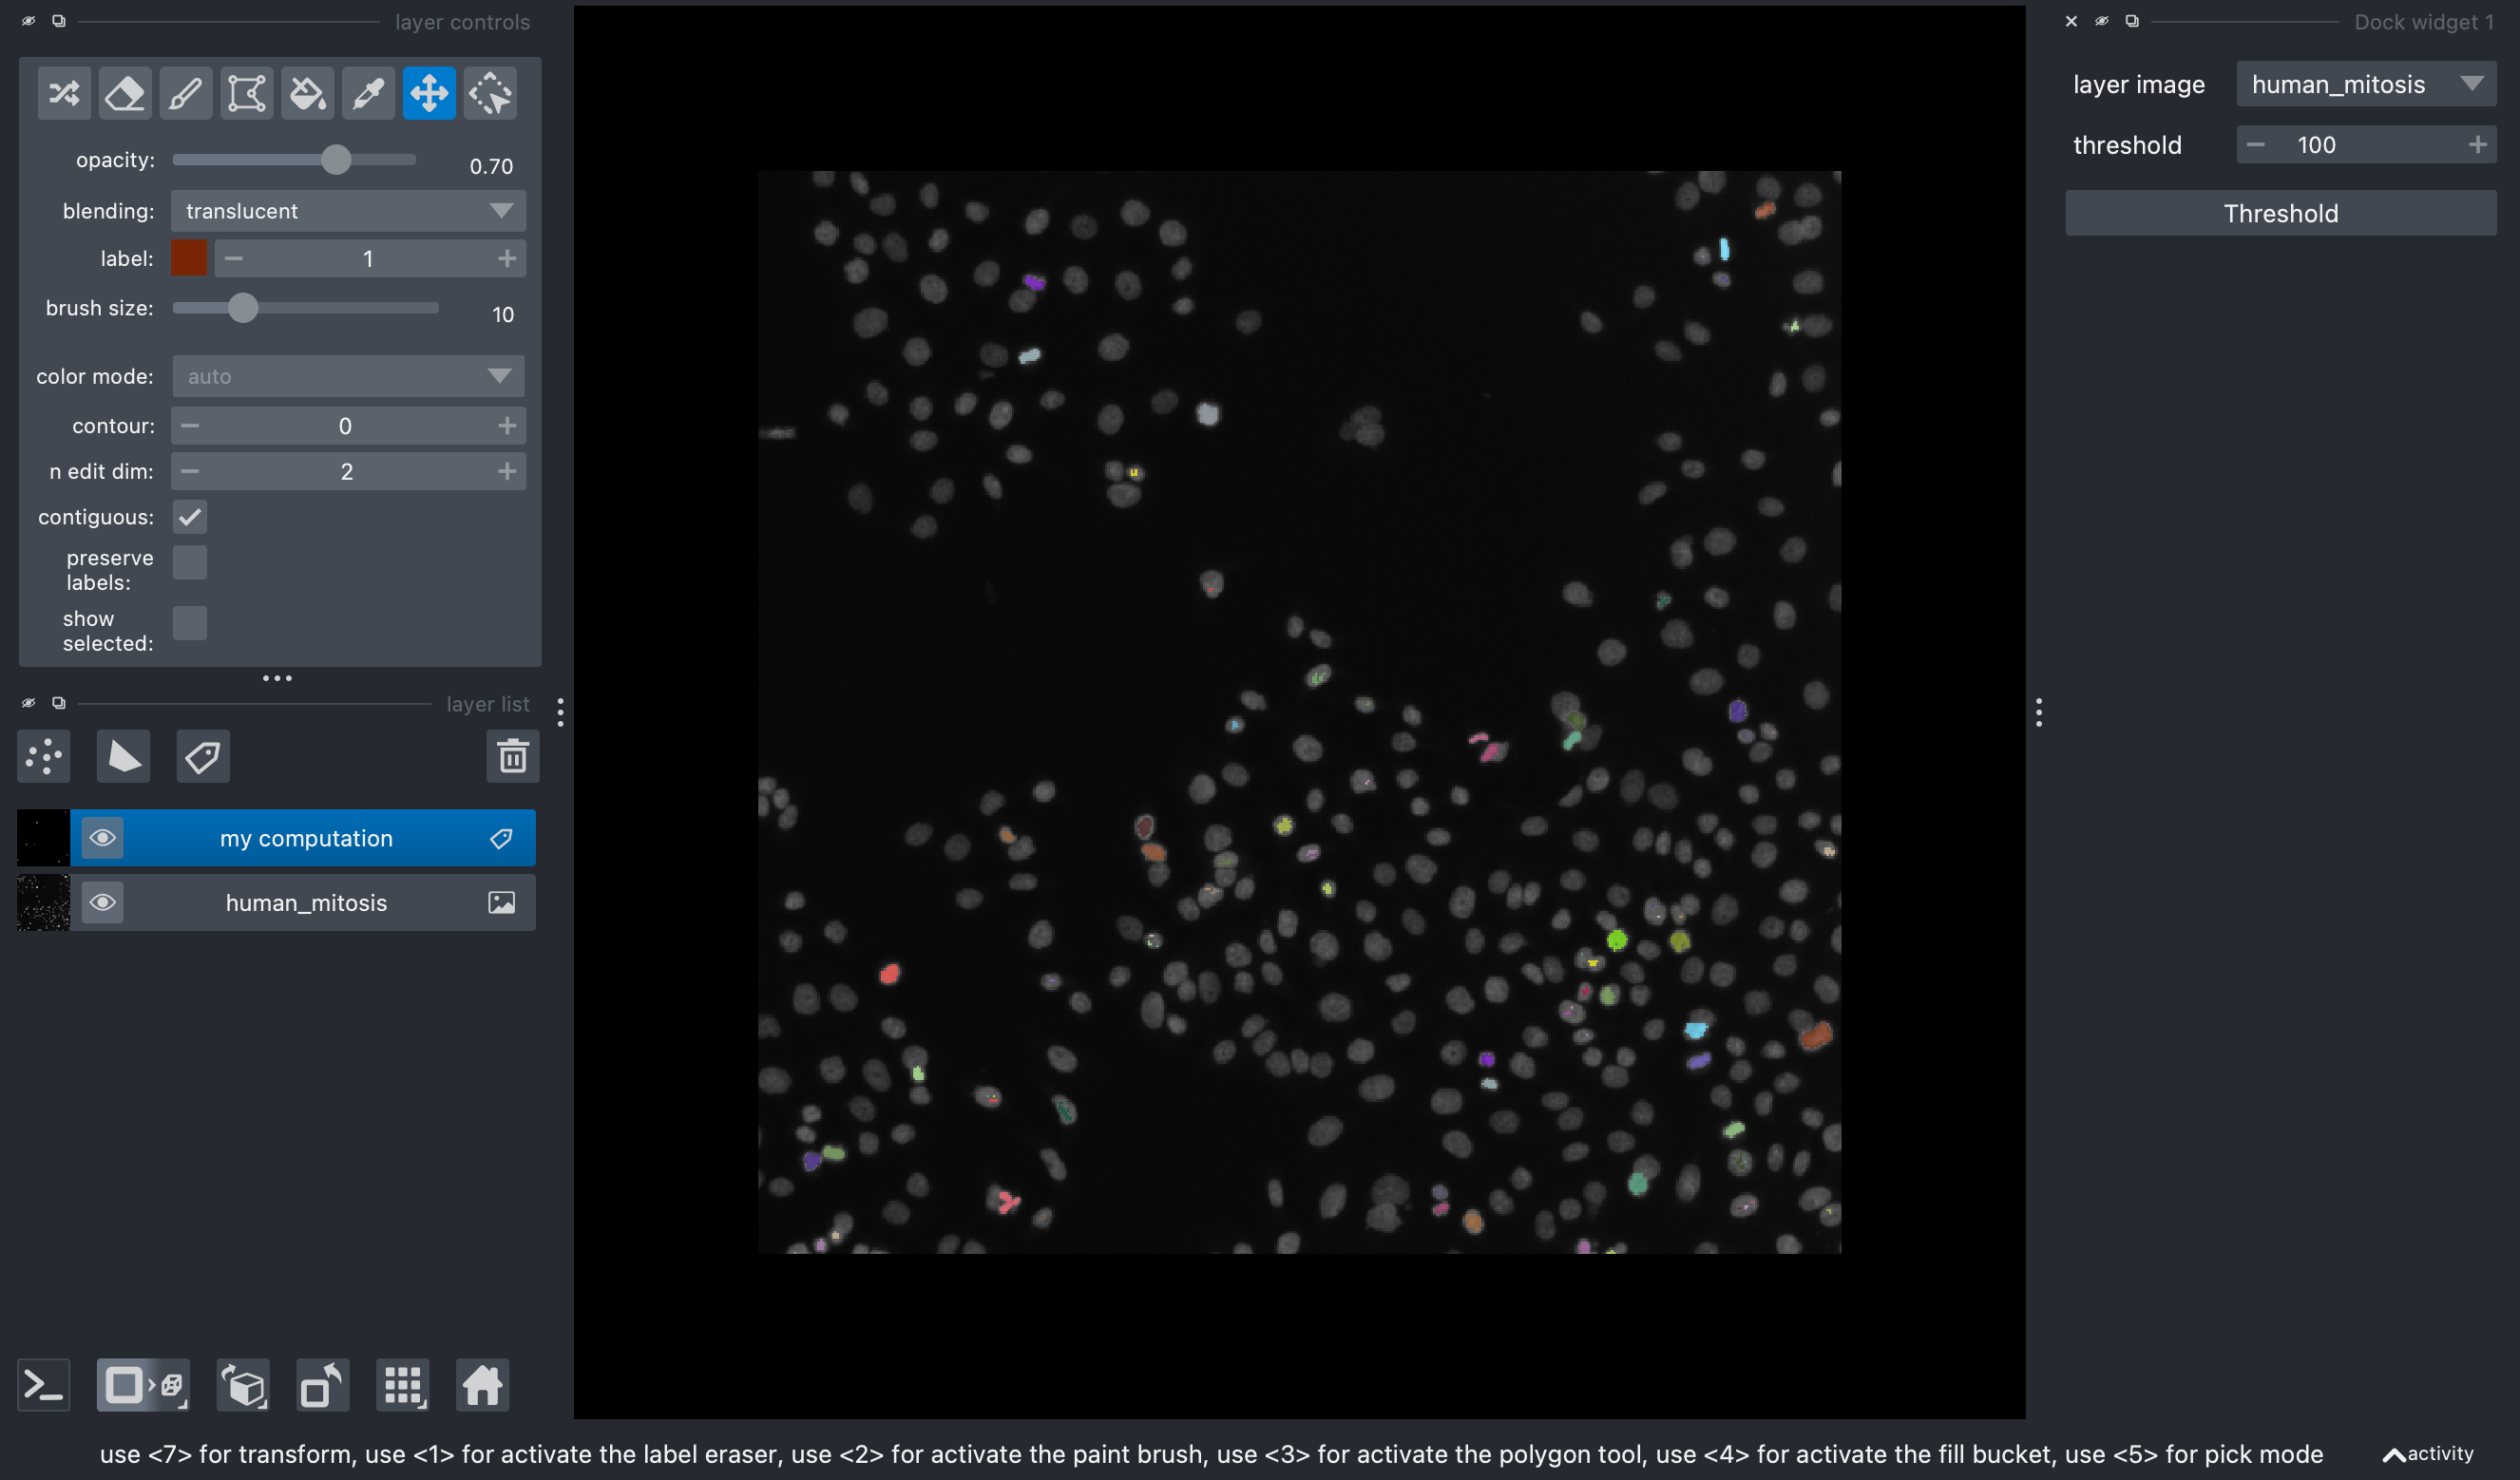

In [25]:
nbscreenshot(viewer)

We can also have access to each part of the widget via the ```native``` property which return a ```QWidget``` the core building block of GUIs created with magicgui. In the next chapter, we will learn more about these Qt and these objects.

In [26]:
mywidget.native.children()

## Exercise

In this chapter we have defined an interface to perform thresholding that we reproduce below. Create a new widget that takes the labelled output as input, uses ```skimage.measure.regionprops_table``` to compute the ```centroid``` of the objects and return them into a ```Points``` layer. Add the widget to the viewer and test it.

In [ ]:
import napari
from napari.types import LabelsData
from magicgui import magic_factory
import skimage

@magic_factory(call_button="execute", layout="vertical")
def workflow(layer_image: "napari.layers.Image", threshold=100) -> LabelsData:
    im_th = layer_image.data > threshold
    im_th = skimage.measure.label(im_th)
    return im_th

mywidget = workflow()

In [ ]:
viewer = napari.Viewer()
viewer.open_sample(plugin='napari', sample='human_mitosis')
threshold_widget = workflow()
viewer.window.add_dock_widget(threshold_widget, area="right");